In [1]:
import os
from datetime import datetime
from PIL import Image
from shutil import copyfile

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as metrics

import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, models
from torch.utils.data.sampler import SubsetRandomSampler
from torch import nn
from torch import optim

from model import Net

import utils

sns.set()

In [2]:
print(torch.__version__)

1.2.0


In [3]:
data_dir = "dataset/"
train_dir = data_dir + "train/"
valid_dir = data_dir + "valid/"

now = datetime.now()
dt_string = now.strftime("%d%m%Y-%H%M%S")
model_target_folder = "models/model-" + dt_string + "/"

In [4]:
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 128

# Load the dataset

In [5]:
transform_train = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.RandomHorizontalFlip(), 
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
])
transform_validation_test = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Define transforms used for the training and validation sets
data_transforms = [transform_train, transform_validation_test]

# Load the datases with ImageFolder (NOTE: if everything goes wrong this is the problem)
train_data = datasets.ImageFolder(train_dir, transform=data_transforms[0])
valid_data = datasets.ImageFolder(valid_dir, transform=data_transforms[1])

# Using the image datasets and the trainforms, define the dataloaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, num_workers=num_workers)

# Classes in the dataset

In [6]:
import json

# Get classes names
classes = {}
for index, name in enumerate(train_data.classes):
    classes[index] = name
    
# Save to JSON
with open('labels_to_class_names.json', 'w', encoding='utf-8') as file:
    json.dump(classes, file, ensure_ascii=False, indent=4)

# Show classes
classes

{0: 'bicycle',
 1: 'bus',
 2: 'car',
 3: 'motorcycle',
 4: 'pickuptruck',
 5: 'truck',
 6: 'van'}

# Visualization of the classes

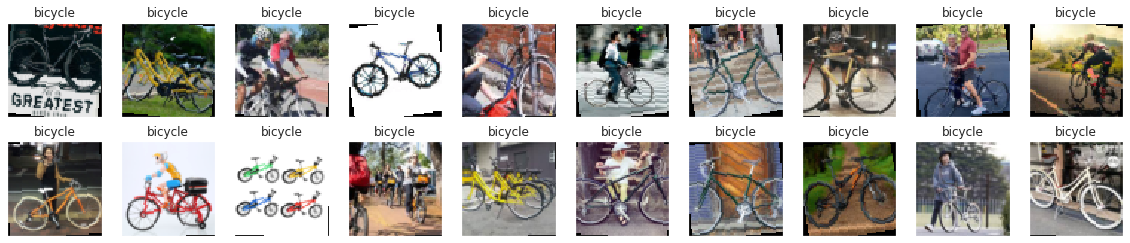

In [7]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images, labels = images.numpy(), labels.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))

for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    utils.imshow(images[idx])
    ax.set_title(classes[labels[idx]])

# Building Classifier

In [8]:
model = Net()
model

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=16384, out_features=2048, bias=True)
  (fc2): Linear(in_features=2048, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=7, bias=True)
  (dropout20): Dropout(p=0.2, inplace=False)
)

# Model Params

In [9]:
n_epochs = 1000
learning_rate = 0.0001
max_epochs_without_improvement = 15

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999))

# Training the classifier

In [10]:
%%time

utils.create_directory(model_target_folder)
copyfile("model.py", model_target_folder + "model.py")

train_on_gpu = torch.cuda.is_available()
model.class_to_idx = train_data.class_to_idx

#train_on_gpu = False
valid_loss_min = np.Inf # track change in validation loss
if(train_on_gpu):
    model.cuda()
else:
    model.cpu()
    
epochs_without_improvement = 0
valid_losses = []
valid_accs = []
valid_precs = []
valid_recalls = []

train_losses = []
train_accs = []
train_precs = []
train_recalls = []
for epoch in range(1, n_epochs+1):
    # keep track of training and validation loss
    y_true_train = []
    y_true_valid = []
    y_pred_train = []
    y_pred_valid = []
    train_loss = 0.0
    valid_loss = 0.0
    
    
    ###################
    # train the model #
    ###################
    #total = 0
    #correct = 0
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # convert output probabilities to predicted class
        _, pred = torch.max(output, 1)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        # Save the predictions
        y_true_train.append(target.data.cpu())
        y_pred_train.append(pred.data.cpu())
        #total += target.size(0)
        #correct += (pred == target).sum().item()
    #train_acc = 100.0 * (correct / total)
    ######################    
    # validate the model #
    ######################
    #total = 0
    #correct = 0
    model.eval()
    for batch_idx, (data, target) in enumerate(valid_loader):
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # convert output probabilities to predicted class
        _, pred = torch.max(output, 1)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
        # Save the predictions
        y_true_valid.append(target.data.cpu())
        y_pred_valid.append(pred.data.cpu())
        #total += target.size(0)
        #correct += (pred == target).sum().item()
    
    y_true_train = np.array(torch.cat(y_true_train))
    y_pred_train = np.array(torch.cat(y_pred_train))
    y_true_valid = np.array(torch.cat(y_true_valid))
    y_pred_valid = np.array(torch.cat(y_pred_valid))
    
    # Calculate the metrics
    train_acc = metrics.accuracy_score(y_true_train, y_pred_train) * 100.0
    train_prec = metrics.precision_score(y_true_train, y_pred_train, average='macro') * 100.0
    train_recall = metrics.recall_score(y_true_train, y_pred_train, average='macro') * 100.0
    
    valid_acc = metrics.accuracy_score(y_true_valid, y_pred_valid) * 100.0
    valid_prec = metrics.precision_score(y_true_valid, y_pred_valid, average='macro') * 100.0
    valid_recall = metrics.recall_score(y_true_valid, y_pred_valid, average='macro') * 100.0
    #valid_acc = 100.0 * (correct / total)
    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
    
    train_accs.append(train_acc)
    valid_accs.append(valid_acc)
    train_precs.append(train_prec)
    valid_precs.append(valid_prec)
    train_recalls.append(train_recall)
    valid_recalls.append(valid_recall)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
        
    # print training/validation statistics 
    print('Epoch {} Training Loss: {:.6f}      \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    print('        Training Accuracy: {:.2f}%\tValidation Accuracy: {:.2f}%'.format(
        train_acc, valid_acc))
    print('        Training Precision: {:.2f}%\tValidation Precision: {:.2f}%'.format(
        train_prec, valid_prec))
    print('        Training Recall: {:.2f}%\t\tValidation Recall: {:.2f}%'.format(
        train_recall, valid_recall))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:         
        epochs_without_improvement = 0
        print('        Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        state = {'epoch': epoch,
                 'learning_rate': learning_rate,
                 'batch_size': batch_size,
                 'state_dict': model.state_dict(),
                 'optimizer': optimizer.state_dict(), 
                 'valid_loss': valid_loss,
                 'valid_acc': valid_acc,
                 'valid_prec': valid_prec,
                 'valid_recall': valid_recall,
                 'train_loss': train_loss,
                 'train_acc': train_acc,
                 'train_prec': train_prec,
                 'train_recall': train_recall,
                 'criterion': criterion, 
                 'class_to_idx': model.class_to_idx,
                 'transform': transform_validation_test,
                 'labels_map': classes}
        torch.save(state, model_target_folder + 'model.pt')

        valid_loss_min = valid_loss
    else:
        epochs_without_improvement += 1
    # Early Stopping
    if epochs_without_improvement > max_epochs_without_improvement:
        print("\nTraining finished due to %s epochs without improvement\n" % max_epochs_without_improvement)
        break
    print("")

/home/rodrigoamf/anaconda3/envs/vehicle-classification/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Epoch 1 Training Loss: 2.814550      	Validation Loss: 1.893365
        Training Accuracy: 5.45%	Validation Accuracy: 20.09%
        Training Precision: 1.94%	Validation Precision: 2.87%
        Training Recall: 7.36%		Validation Recall: 14.29%
        Validation loss decreased (inf --> 1.893365).  Saving model ...

Epoch 2 Training Loss: 1.951251      	Validation Loss: 1.897590
        Training Accuracy: 14.56%	Validation Accuracy: 20.09%
        Training Precision: 12.84%	Validation Precision: 2.87%
        Training Recall: 10.96%		Validation Recall: 14.29%

Epoch 3 Training Loss: 1.941490      	Validation Loss: 1.889030
        Training Accuracy: 13.59%	Validation Accuracy: 20.09%
        Training Precision: 5.69%	Validation Precision: 2.87%
        Training Recall: 10.20%		Validation Recall: 14.29%
        Validation loss decreased (1.893365 --> 1.889030).  Saving model ...

Epoch 4 Training Loss: 1.918188      	Validation Loss: 1.879800
        Training Accuracy: 14.81%	Validation


Epoch 27 Training Loss: 1.599011      	Validation Loss: 1.552277
        Training Accuracy: 38.00%	Validation Accuracy: 38.89%
        Training Precision: 40.30%	Validation Precision: 48.61%
        Training Recall: 35.85%		Validation Recall: 36.16%
        Validation loss decreased (1.567760 --> 1.552277).  Saving model ...

Epoch 28 Training Loss: 1.577918      	Validation Loss: 1.536704
        Training Accuracy: 39.38%	Validation Accuracy: 39.10%
        Training Precision: 42.94%	Validation Precision: 49.49%
        Training Recall: 37.34%		Validation Recall: 36.83%
        Validation loss decreased (1.552277 --> 1.536704).  Saving model ...

Epoch 29 Training Loss: 1.549820      	Validation Loss: 1.522974
        Training Accuracy: 39.38%	Validation Accuracy: 38.68%
        Training Precision: 43.13%	Validation Precision: 47.30%
        Training Recall: 37.96%		Validation Recall: 36.90%
        Validation loss decreased (1.536704 --> 1.522974).  Saving model ...

Epoch 30 Traini

Epoch 54 Training Loss: 0.807310      	Validation Loss: 1.366263
        Training Accuracy: 72.42%	Validation Accuracy: 49.57%
        Training Precision: 74.24%	Validation Precision: 53.03%
        Training Recall: 72.98%		Validation Recall: 51.11%

Epoch 55 Training Loss: 0.749411      	Validation Loss: 1.374316
        Training Accuracy: 74.37%	Validation Accuracy: 47.22%
        Training Precision: 76.17%	Validation Precision: 50.84%
        Training Recall: 75.81%		Validation Recall: 47.69%

Epoch 56 Training Loss: 0.712602      	Validation Loss: 1.382275
        Training Accuracy: 76.81%	Validation Accuracy: 48.50%
        Training Precision: 79.64%	Validation Precision: 50.45%
        Training Recall: 77.69%		Validation Recall: 49.67%

Epoch 57 Training Loss: 0.670953      	Validation Loss: 1.411462
        Training Accuracy: 78.68%	Validation Accuracy: 46.79%
        Training Precision: 79.69%	Validation Precision: 50.41%
        Training Recall: 79.23%		Validation Recall: 47.5

# Plot model performance during the training

In [15]:
epochs = list(range(1, len(valid_losses)+1))
best_model_epoch = epoch - max_epochs_without_improvement - 1
markers_on = [best_model_epoch]

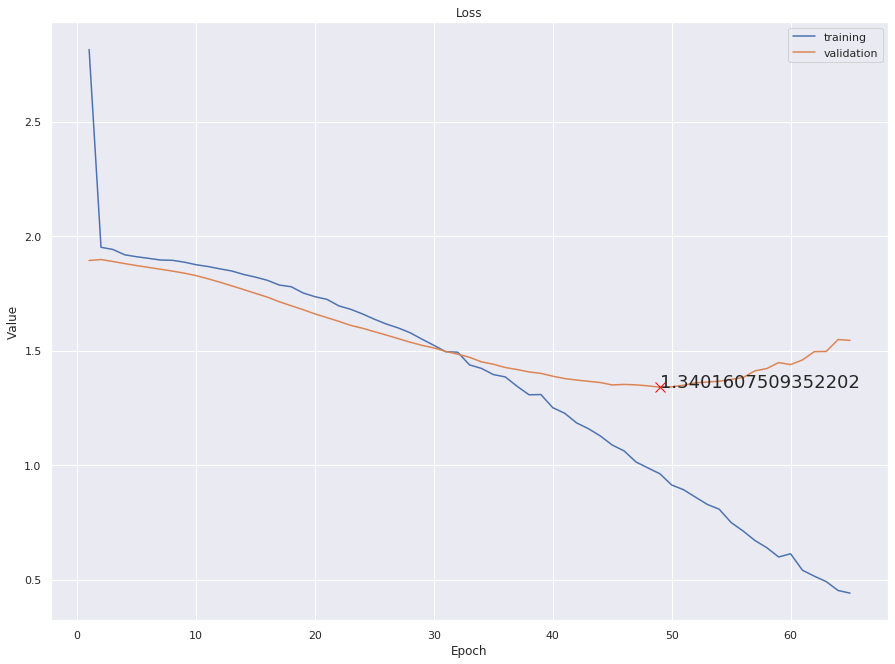

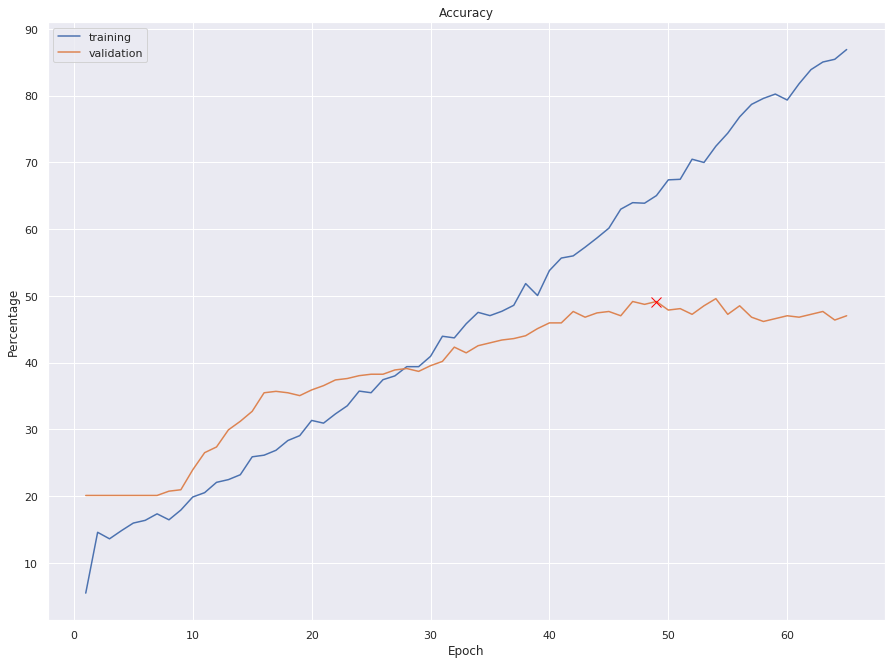

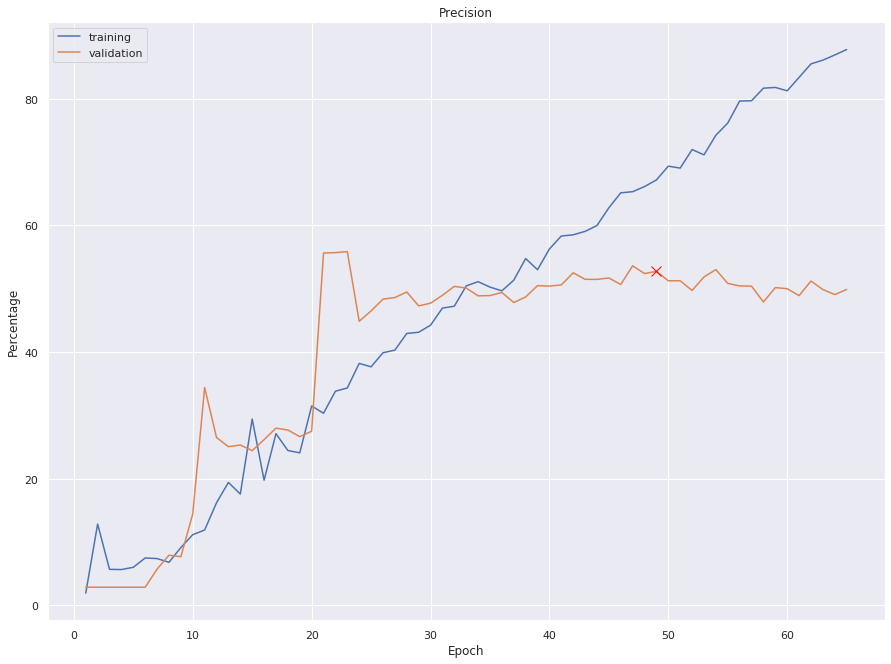

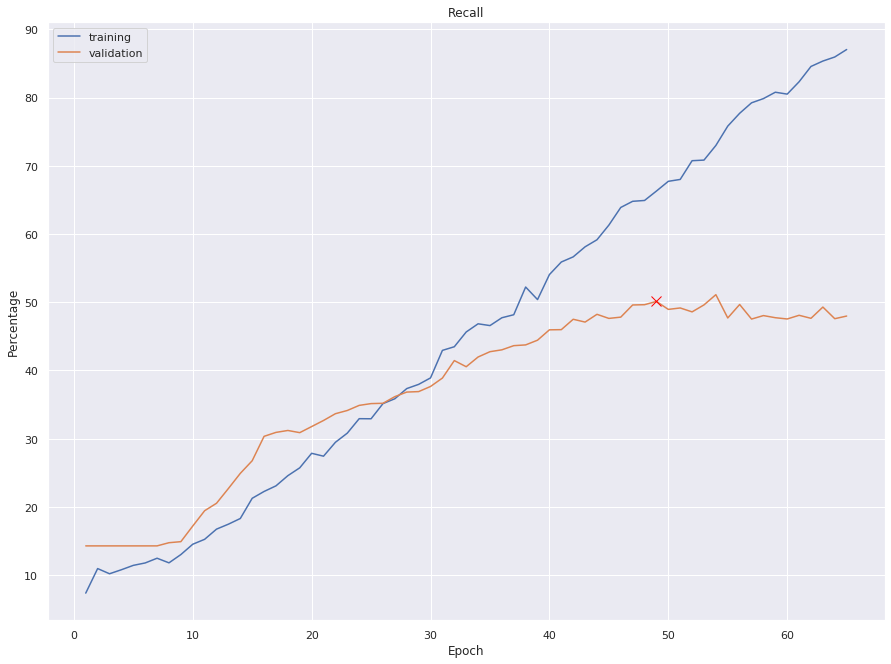

In [31]:
fig = plt.figure(figsize = (15,11))

plt.plot(epochs, train_losses, label='training')
plt.plot(epochs, valid_losses, label='validation')
plt.plot(best_model_epoch, valid_losses[best_model_epoch - 1], marker='x', markersize=10, color="red")
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title("Loss")
plt.legend()
fig.savefig(model_target_folder + 'loss.png', dpi=fig.dpi)

plt.show()

fig = plt.figure(figsize = (15,11))
plt.plot(epochs, train_accs, label='training')
plt.plot(epochs, valid_accs, label='validation')
plt.plot(best_model_epoch, valid_accs[best_model_epoch - 1], marker='x', markersize=10, color="red")
plt.xlabel('Epoch')
plt.ylabel('Percentage')
plt.title("Accuracy")
plt.legend()
fig.savefig(model_target_folder + 'accuracy.png', dpi=fig.dpi)

fig = plt.figure(figsize = (15,11))
plt.plot(epochs, train_precs, label='training')
plt.plot(epochs, valid_precs, label='validation')
plt.plot(best_model_epoch, valid_precs[best_model_epoch - 1], marker='x', markersize=10, color="red")
plt.xlabel('Epoch')
plt.ylabel('Percentage')
plt.title("Precision")
plt.legend()
fig.savefig(model_target_folder + 'precision.png', dpi=fig.dpi)

fig = plt.figure(figsize = (15,11))
plt.plot(epochs, train_recalls, label='training')
plt.plot(epochs, valid_recalls, label='validation')
plt.plot(best_model_epoch, valid_recalls[best_model_epoch - 1], marker='x', markersize=10, color="red")
plt.xlabel('Epoch')
plt.ylabel('Percentage')
plt.title("Recall")
plt.legend()
fig.savefig(model_target_folder + 'recall.png', dpi=fig.dpi)

plt.show()